# Problem 5 - Recommender systems

### Task 0 - preparing the data

In [2]:
import pandas as pd
from pandas.io.common import ZipFile
from requests import get

import numpy as np
import scipy as sp
from scipy import sparse

from collections import namedtuple
import sys

In [3]:
if sys.version_info[0] < 3:
    from StringIO import StringIO
else:
    from io import StringIO 

In [4]:
def get_movielens_data(local_file):
    '''Downloads movielens data, normalizes users and movies ids,
    returns data in sparse CSR format.
    '''
    if not local_file:
        print 'Downloading data...'
        zip_file_url = 'http://files.grouplens.org/datasets/movielens/ml-10m.zip'
        zip_response = get(zip_file_url)
        zip_contents = StringIO(zip_response.content)
        print 'Done.'
    else:
        zip_contents = local_file
    
    print 'Loading data into memory...'
    with ZipFile(zip_contents) as zfile:
        zdata = zfile.read('ml-10M100K/ratings.dat')
        delimiter = ';'
        zdata = zdata.replace('::', delimiter) # makes data compatible with pandas c-engine
        ml_data = pd.read_csv(StringIO(zdata), sep=delimiter, header=None, engine='c',
                                  names=['userid', 'movieid', 'rating', 'timestamp'],
                                  usecols=['userid', 'movieid', 'rating'])
    
    # normalize indices to avoid gaps
    ml_data['movieid'] = ml_data.groupby('movieid', sort=False).grouper.group_info[0]
    ml_data['userid'] = ml_data.groupby('userid', sort=False).grouper.group_info[0]
    
    # build sparse user-movie matrix
    data_shape = ml_data[['userid', 'movieid']].max() + 1
    data_matrix = sp.sparse.csr_matrix((ml_data['rating'],
                                       (ml_data['userid'], ml_data['movieid'])),
                                        shape=data_shape, dtype=np.float64)
    
    print 'Done.'
    return data_matrix

In [5]:
def split_data(data, test_ratio=0.2):
    '''Randomly splits data into training and testing datasets. Default ratio is 80%/20%.
    Returns datasets in namedtuple format for convenience. Usage:
    train_data, test_data = split_data(data_matrix)
    or
    movielens_data = split_data(data_matrix)
    and later in code: 
    do smth with movielens_data.train 
    do smth with movielens_data.test
    '''
    
    num_users = data.shape[0]
    idx = np.zeros((num_users,), dtype=bool)
    sel = np.random.choice(num_users, test_ratio*num_users, replace=False)
    np.put(idx, sel, True)
    
    Movielens_data = namedtuple('MovieLens10M', ['train', 'test'])
    movielens_data = Movielens_data(train=data[~idx, :], test=data[idx, :])
    return movielens_data

In [6]:
local_file='C:/Users/frike/Documents/!botanstvo/SkolTech/NLA/ProblemSet3/ml-10m.zip'
data = get_movielens_data(local_file)
movielens_data = split_data(data)

Loading data into memory...
Done.


C:\Users\frike\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Task 1 - building the core of reccomender

In [7]:
sparsity = np.float64(movielens_data.train.nnz)/(movielens_data.train.shape[0]*movielens_data.train.shape[1])
print sparsity

0.0133800329905


In [8]:
import scipy.sparse
import scipy.sparse.linalg
r = 100
u, s, v = scipy.sparse.linalg.svds(movielens_data.train, r)
u = np.ascontiguousarray(u[:,::-1])
s = np.ascontiguousarray(s[::-1])
v = np.ascontiguousarray(v[::-1,:])

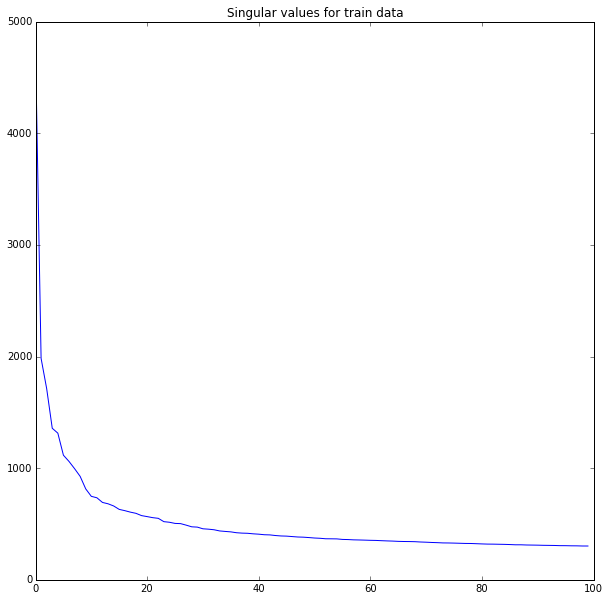

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(s)
plt.title('Singular values for train data')

The graph goes to a straight, but does not reach the downturn, so the data has a low-rank structure. About 40 values would be sufficient for my model.

In [106]:
r = 200
u, s, v = scipy.sparse.linalg.svds(movielens_data.train, r)

In [107]:
u = np.ascontiguousarray(u[:,::-1])
s = np.ascontiguousarray(s[::-1])
v = np.ascontiguousarray(v[::-1,:])

In [108]:
num_users = movielens_data.train.shape[0]
print num_users
idx = np.zeros((num_users,), dtype=int)
sel = np.random.choice(num_users,5,replace = False)
np.put(idx, sel, 1)
#mov_rec = idx.T.dot(u).dot(np.diag(s)).dot(v)

55903


In [109]:
q = np.zeros((num_users,5))
j = 0
for i,ind in enumerate(idx):
    if (ind != 0):
        q[i,j] = 1
        j += 1
mov_rec = q.T.dot(u).dot(np.diag(s)).dot(v)
mov = (movielens_data.train.T.dot(q)).T
rate = scipy.argsort(mov,axis = 1)[:,-10:][:,::-1]
top_10 = scipy.argsort(mov_rec,axis = 1)[:,-10:][:,::-1]
print top_10
print rate


[[ 381 1005    9   62   94   60  146  192  279   16]
 [1293  133   72 1292  164  156  139   24   74 1024]
 [ 259 1093  489  543  258  633  621   37  206 1920]
 [ 605  220   44  625   22  195  140    7  178  139]
 [  74   72   85 1479  175   18   93   94   75   79]]
[[1211   36  993  399  311  301  133 2070  284  192]
 [1293   72  218  164  402 1024  241  381  133  419]
 [ 259 1362 1920  577  606 1610  201  589  164  638]
 [4180 1082  148  146 2152  140  139 3016 1134 1312]
 [1479   74    1  314  313   88  306   85   72 1412]]


In [111]:
N = 10
from scipy.sparse import csr_matrix
num_users = movielens_data.test.shape[0]
num_movies = movielens_data.test.shape[1]
top_N = np.zeros((num_users,N))
for i in xrange(5):
    x = np.zeros(num_movies)
    __,ind = csr_matrix.nonzero(movielens_data.test[i])
    history = ind[:len(ind)-N]
    evaluation = ind[len(ind)-N:]
    for j in history:
        x[j] += movielens_data.test[i,j]
    r = v.T.dot(v.dot(x))
    top_N[i] = scipy.argsort(r)[-N:][::-1].astype(np.int64)
    print evaluation
    print top_N[i]
        
        




[180 179 178 177 176 175 101  83  34  24]
[ 195.  198.  193.  192.  206.  188.  185.  190.  187.  182.]
[259 238 202 198 196 123  79  39  31  30]
[  616.   605.   625.   636.   630.   265.   631.   638.  1770.  1009.]
[16 14 11  9  7  5  4  3  2  1]
[   22.   139.  1008.    18.   213.    85.   133.    74.   101.   102.]
[140 101  38  36  33  31  30  29  28  27]
[ 1494.  1300.    32.  1302.   311.  1283.  1429.  1482.  1303.  1489.]
[92 85 73 50 36 30 20 18  9  7]
[  417.   426.   145.  1328.   381.  1438.   468.   605.   217.   146.]


(array([0, 2, 3], dtype=int64),)
